# Sentiment analysis

Sentiment analysis is a NLP technique to determine the sentiment of a sentence. In this implementation, we will focus on determining the sentiment of the subject of the subject or object or the sentence.

Here I propose some possible sentences for our dataset, indicating where the meaning is encoded.

- Morose man cries. (morose)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Joyful kid laughs. (joyful, laughs)
- Furious man snaps. (furious, snaps)
- Kid startles man. (startles)
- Woman grieves man. (grieves)
...


| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | cries | morose |
| Woman | laughs | irascible |
| Kid | shouts | frightened |
|  | snaps | cheerful |
|  | entertains | gloomy |
|  | grieves | furious |
|  | startles | terrified |
|  | irritates |joyful|

The proposed vocabulary has 19 words and two different kind of sentences:
- Adj + Subject + Intransitive verb
- Subject + Transitive verb + Object

## 1. Create dataset

The first step is to create a dataset using the presented vocabulary. We have to store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish two different types of verbs: transitive and intransitive. 

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
downcast, miserable = Word('downcast', n @ n.l), Word('miserable', n @ n.l)
old, young = Word('old', n @ n.l), Word('young', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful, downcast, miserable, old, young]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- adj + noun + int. verb
- noun + t. verb + noun

- Intransitive sentence

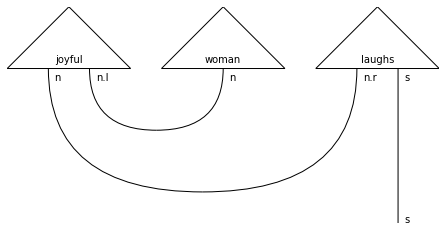

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = joyful @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

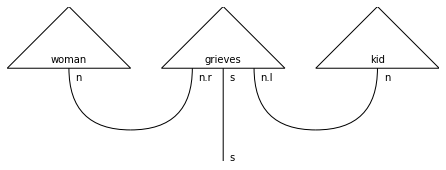

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

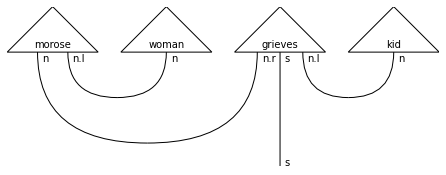

In [5]:
grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = morose @ woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

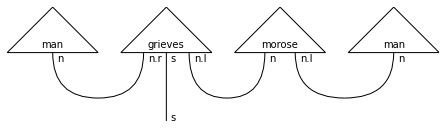

In [6]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)
sentence =  man @ grieves @ morose @ man >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [7]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n),
    'ADJ_N_TV_N': Id(n) @ Cup(n.l, n) @ Id(n.r @ s) @ Cup(n.l, n) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_ADJ_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n) @ Cup(n.l, n) >> Id(s)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences (without adjective)
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}


# Transitive sentences (with adjective)
parsing_tra_ladj = {"{} {} {} {}.".format(adj, subj, t_verb, obj):  adj @ subj @ t_verb @ obj >> grammar_dict['ADJ_N_TV_N']
            for adj in adjectives for subj in nouns for t_verb in t_verbs for obj in nouns}
parsing_tra_radj = {"{} {} {} {}.".format(subj, t_verb, adj, obj):  subj @ t_verb @ adj @ obj >> grammar_dict['N_TV_ADJ_N']
            for subj in nouns for t_verb in t_verbs for adj in adjectives for obj in nouns}

parsing_tra.update(parsing_tra_ladj) #merges transitive adjectives into original dict
parsing_tra.update(parsing_tra_radj)

sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. The next step is to design the corresponding quantum circuits to determine the sentiment for each sentence. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Old man cries'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences.

### 1.3. Process the data

In [8]:
with open('./sentiment_analysis_dataset.txt') as f:
    data = f.readlines()

In [9]:
labels_dict = {}
data_psr_dict = {}
sent_type = {}

adjective_words = [a.name for a in adjectives]
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]

        if len(sentstr.split()) == 4:
            if sentstr.split()[0] in adjective_words:
                sent_type[sentstr] = 'tra_' + 'l'
            else:
                sent_type[sentstr] = 'tra_' + 'r'
        else:
            sent_type[sentstr] = 'tra'
            

In [10]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  90
Sad:  96
Angry:  92
Scared:  87
Total 365


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

- Intransitive sentence

In [11]:
from discopy import Cap, Box

woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (joyful @ Id(n) @ woman2 @ laughs)
sentence = words_new >> grammar_dict['ADJ_N_IV']
sentence = sentence.normal_form()

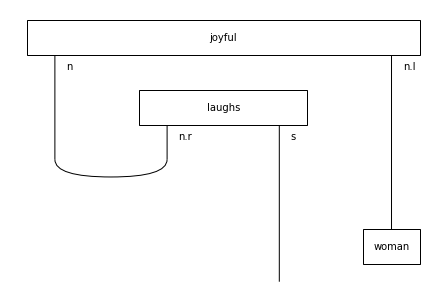

In [12]:
sentence.draw()

- Transitive sentence

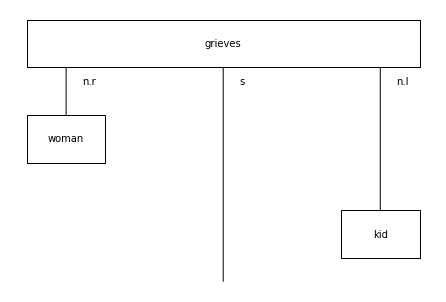

In [13]:
woman2 = Box('woman', n.r, Ty())
kid2 = Box('kid', n.l, Ty())
words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (woman2 @ Id(n) @ grieves @ Id(n) @ kid2)
sentence = words_new >> grammar_dict['N_TV_N']
sentence = sentence.normal_form()
sentence.draw()

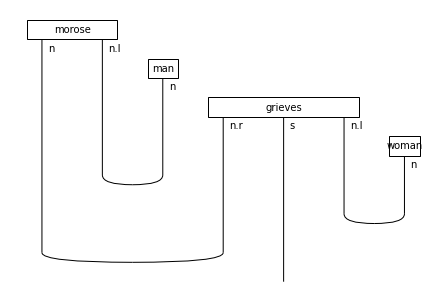

In [14]:
data_psr['morose man grieves woman.'].draw()

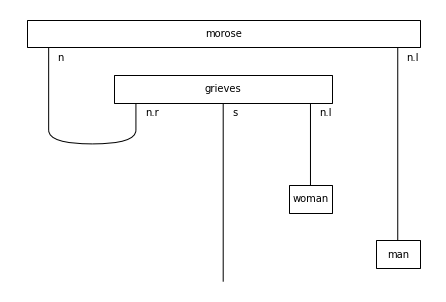

In [15]:
man2 = Box('man', n.l, Ty()) #I changed this to n.l to make everything fit but Im not certain I can just do that
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (morose @ Id(n) @ man2 @ grieves @ Id(n) @ woman2)
sentence = words_new >> grammar_dict['ADJ_N_TV_N']
sentence = sentence.normal_form()
sentence.draw()

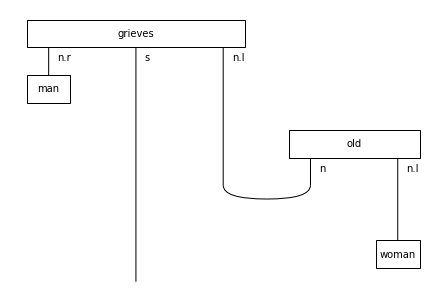

In [16]:
man2 = Box('man', n.r, Ty())
woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (man2 @ Id(n) @ grieves @ old @ Id(n) @ woman2)
sentence = words_new >> grammar_dict['N_TV_ADJ_N']
sentence = sentence.normal_form()
sentence.draw()

Let us apply this to our entire dataset.

In [17]:
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'tra':
        if num_words == 3:
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[2].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        elif words[0] in adjectives: #adjective at beginning
            noun1 = Box(words[1].name, n.l, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['ADJ_N_TV_N']
            data_new_psr_dict[sentstr] = sentence.normal_form()
        else: #adjective on second noun
            noun1 = Box(words[0].name, n.r, Ty())
            noun2 = Box(words[3].name, n.l, Ty())
            words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
            sentence = words_new >> grammar_dict['N_TV_ADJ_N']
            data_new_psr_dict[sentstr] = sentence.normal_form() 

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [18]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Create quantum circuit

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have two types of words, nouns and verbs. Both types will have associated 2 qubits (as we have four sentiments, we need 4 quantum states to encode the result of the classification). Moreover, we will also distinguish between states and effects when constructing the ansätze.

In [19]:
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial
from discopy.quantum.gates import Rx, Rz

import numpy as np

q_s = 1 # number of qubits for type s (sentence)
q_n = 1 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz
p_n = 3 # number of parameters for the single qubit iqp ansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects

def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)     
    
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [20]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [21]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     33


In [22]:
# Print the quantum circuit for each sentence

func = F(rand_shaped_pars)

for sentstr in data_new_psr_dict:
    print(sentstr)
    print(data_new_psr_dict[sentstr])
    #func(data_new_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))

morose woman cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
morose woman shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
morose man cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ man
morose man shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ man
morose kid cries.
morose >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ kid
morose kid shouts.
morose >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ kid
irascible woman cries.
irascible >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible woman shouts.
irascible >> Id(n) @ shouts @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible woman snaps.
irascible >> Id(n) @ snaps @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> Id(s) @ woman
irascible man cries.
irascible >> Id(n) @ cries @ Id(n.l) >> Cup(n, n.r) @ Id(s @ n.l) >> 

## 3. Create training and test dataset

The next step is to divide our dataset into training and test data, so we can perform the classification using a supervised quantum machine learning technique. We need the data, which are the quantum circuits associated to each sentences, and the labels, that encode the sentiment. In this case the labels are the four possible quantum states that can be obtained from measuring a 2-qubit quantum circuit:

- Happy: $ \ 0 \ \rightarrow \ |00\rangle = [1,0,0,0] \ \rightarrow \ p_{00}=1$,
- Sad: $ \ 1 \ \rightarrow \ |01\rangle = [0,1,0,0] \ \rightarrow \ p_{01}=1$,
- Angry: $ \ 2 \ \rightarrow \ |10\rangle = [0,0,1,0] \ \rightarrow \ p_{10}=1$,
- Scared: $ \ 3 \ \rightarrow \ |11\rangle = [0,0,0,1] \ \rightarrow \ p_{11}=1$.

In [23]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    label = int(labels_dict[sentstr])
    psr_labels.append(label)

train_data_psr, test_data_psr, orig_train_labels, orig_test_labels = \
    train_test_split(psr_diagrams, psr_labels, test_size=0.25, random_state=42)
train_sent, test_sent, train_labels_sent, test_labels_sent = \
    train_test_split(sentences, psr_labels, test_size=0.25, random_state=42)

In [24]:
def num_to_vec(x):
    if x:
        return [0,1] #True
    else:
        return [1,0]

data_sets_labels = {}
for i, cla in enumerate(['happy', 'sad', 'angry', 'scared']):
    data_sets_labels[cla] = {}
    
    tr_labels = [num_to_vec(i == t) for t in orig_train_labels]
    data_sets_labels[cla]['train'] = tr_labels
    
    te_labels = [num_to_vec(i == t) for t in orig_test_labels]
    data_sets_labels[cla]['test'] = te_labels

## 4. Qiskit Implementation

In [25]:
from qiskit import BasicAer, execute, ClassicalRegister
from pytket.extensions.qiskit import tk_to_qiskit
from qiskit.quantum_info import Statevector



backend = BasicAer.get_backend('qasm_simulator')
max_shots = 8192

n_iterations = 500

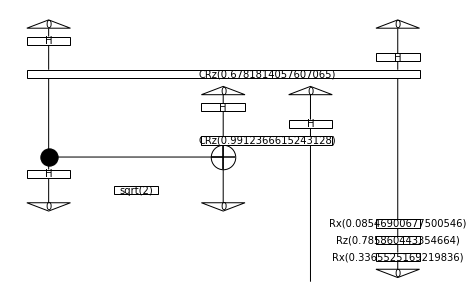

In [26]:
func(data_new_psr_dict['morose woman cries.']).draw()

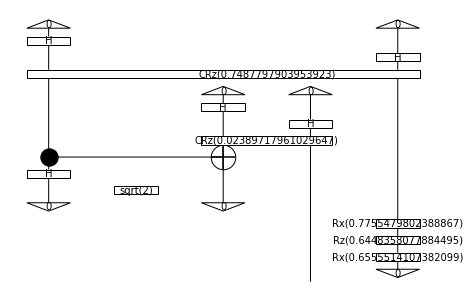

In [27]:
func(data_new_psr_dict['terrified man shouts.']).draw()

In [28]:
sent_type['joyful kid entertains woman.']

'tra_l'

In [29]:
def get_qiskit_results(circ, sent, transpile=False, retries=10):
    assert not transpile, "transpile not implemented yet"
    
        
    s_type = sent_type[sent]
    
    if s_type == 'int':
        n_qubits = 4
        post = 2
    elif s_type == 'tra':
        n_qubits = 3
        post = 1
    elif s_type == 'tra_l':
        n_qubits = 5
        post = 2
    else:
        assert s_type == 'tra_r'
        n_qubits = 5
        post = 1
    
        
    qc = tk_to_qiskit(circ.to_tk())
    

    
    qc.remove_final_measurements()
    
    state_dict = Statevector(qc).to_dict()
    
    selections = ['0' * post + val + '0' * (n_qubits - post - 1) for val in ['0', '1']]
    
    #print(selections, state_dict, sent, s_type)
    
    return [np.abs(state_dict[sel])**2 for sel in selections]
    
    

def parse_results(results, eff='0'):
    ks = [k for k in results.keys() if k.split()[1] == eff]
    post_selected_results = {k.split()[0]:v for (k,v) in results.items() if k in ks}
    
    if '0' not in post_selected_results:
        post_selected_results['0'] = 0
    if '1' not in post_selected_results:
        post_selected_results['1'] = 0
        
    total = post_selected_results['0'] + post_selected_results['1']
    
    assert total > 0, 'total was 0 after postselection - try running with more shots'
    
    
    return [post_selected_results['0']/total,  post_selected_results['1']/total]
    

In [30]:
from qiskit.algorithms.optimizers import SPSA
import time

global_costs = []

def old_cost(unshaped_params):
    probs = get_probs(unshaped_params)
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(train_data_psr) * np.sum(cross_entropies) 


def cost_ce(unshaped_params):
    
    func = F(reshape_params(unshaped_params, par_shapes))
    
    circs = [func(diag) for diag in train_data_psr]
    
    results = np.array([get_qiskit_results(circs[i], train_sent[i]) for i in range(len(train_sent))])

    
    results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results] #from before
    pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
    
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    c = -1 / len(train_data_psr) * np.sum(cross_entropies)
    
    global_costs.append(c)
    
    return c

def cost_te(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    
    circs = [func(diag) for diag in train_data_psr]
    
    results = np.array([get_qiskit_results(circs[i], train_sent[i]) for i in range(len(train_sent))])

    
    results_tweaked = [np.abs(np.array(res) - 1e-9) for res in results]
    pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
    
    error = 0
    for i, r in enumerate(pred_labels_distrs):
        error += int(np.argmax(r) != np.argmax(train_labels[i]))
        

    return error/len(pred_labels_distrs)
    


rand_unshaped_pars = randparams(par_shapes)
num_vars = len(rand_unshaped_pars)



bounds = [[0.0, 1.0] for _ in range(len(rand_unshaped_pars))]

ps = {}

n_iterations = 1000

for cla in ['happy', 'sad', 'angry', 'scared']:
    
    
    rand_unshaped_pars = randparams(par_shapes)


    train_labels = data_sets_labels[cla]['train']
    test_labels = data_sets_labels[cla]['test']




    a = time.time()
    opt = SPSA(maxiter=n_iterations)
    print("\n\ncalibrating", cla)
    opt.calibrate(cost_ce, initial_point=rand_unshaped_pars)
    print("training")
    global_costs = []
    o = opt.optimize(num_vars, cost_ce, initial_point=rand_unshaped_pars, variable_bounds=bounds)#, gradient_function=grad_func) 
    ps[cla] = [o, global_costs.copy()]
    print("took", time.time() - a)




calibrating happy
training
took 2869.752683162689


calibrating sad
training
took 2733.3361887931824


calibrating angry
training
took 2842.050894021988


calibrating scared
training
took 2793.037092924118


In [31]:
ps['happy'][0][0]

array([-1.15554938,  2.26378109, -0.01118651, ...,  1.60182342,
        4.11351814,  1.22107876])

In [36]:
final_train_predictions = [(0,'') for _ in range(len(orig_train_labels))] # list of tuples of the form (probability, class)
final_test_predictions = [(0,'') for _ in range(len(orig_test_labels))]

test_predictions_dict = {}

individual_train_predictions = {}
individual_test_predictions = {}
classes = ['happy', 'sad', 'angry', 'scared']
for j, cla in enumerate(classes):
    #params = final_params[cla]
    params = ps[cla][0][0]
    func = F(reshape_params(params, par_shapes))
    
    
    train_data = train_data_psr
    #train_data = data_sets[cla]['train']
    
    train_labels = data_sets_labels[cla]['train']
    test_labels = data_sets_labels[cla]['test']
    
    
    final_train_circuits = [func(diag) for diag in train_data_psr]
    train_results = [get_qiskit_results(final_train_circuits[i], train_sent[i]) for i in range(len(train_sent))]

    final_test_circuits = [func(diag) for diag in test_data_psr]
    test_results = [get_qiskit_results(final_test_circuits[i], test_sent[i]) for i in range(len(test_sent))]

    train_results_tweaked = [np.abs(np.array(res) - 1e-9) for res in train_results]
    test_results_tweaked = [np.abs(np.array(res) - 1e-9) for res in test_results]
    pred_train_results = [res.flatten() / np.sum(res) for res in train_results_tweaked]
    pred_test_results = [res.flatten() / np.sum(res) for res in test_results_tweaked]
    
    
    test_predictions_dict[cla] = ([np.argmax(r) for r in pred_test_results], test_labels)
    
    
    
    #Since each tuple (p, j) in these lists represents a probability that sentence i is in class j, this update keeps 
    #track of the most likely prediction so far
    final_train_predictions = [max(final_train_predictions[i], (pred_train_results[i][1], j)) for i in range(len(pred_train_results))]
    final_test_predictions = [max(final_test_predictions[i], (pred_test_results[i][1], j)) for i in range(len(pred_test_results))]
    
    individual_train_predictions[cla] = [np.argmax(pred) for pred in pred_train_results]
    individual_test_predictions[cla] = [np.argmax(pred) for pred in pred_test_results]

In [37]:
#individual accuracy

for cla in classes:
    train_pred = individual_train_predictions[cla]
    train_actual = data_sets_labels[cla]['train']
    
    acc = [train_pred[i] == np.argmax(train_actual[i]) for i in range(len(train_pred))]
    print("\n\nfor", cla, ": train accuracy =", sum(acc)/len(acc))
    

    test_pred = individual_test_predictions[cla]
    test_actual = data_sets_labels[cla]['test']
    
    acc = [test_pred[i] == np.argmax(test_actual[i]) for i in range(len(test_pred))]
    print("for", cla, ": test accuracy =", sum(acc)/len(acc))
    
    



for happy : train accuracy = 0.8352941176470589
for happy : test accuracy = 0.8620689655172413


for sad : train accuracy = 0.6941176470588235
for sad : test accuracy = 0.6206896551724138


for angry : train accuracy = 0.788235294117647
for angry : test accuracy = 0.7931034482758621


for scared : train accuracy = 0.9647058823529412
for scared : test accuracy = 1.0


In [38]:
from sklearn.metrics import confusion_matrix
for cla in classes:
    
    print("\n\n for", cla, "\n", confusion_matrix([np.argmax(t) for t in test_predictions_dict[cla][1]], test_predictions_dict[cla][0])) #true, pred
    
confusion_matrix(orig_test_labels, [r[1] for r in final_test_predictions])



 for happy 
 [[23  0]
 [ 4  2]]


 for sad 
 [[12  5]
 [ 6  6]]


 for angry 
 [[19  4]
 [ 2  4]]


 for scared 
 [[24  0]
 [ 0  5]]


array([[ 2,  4,  0,  0],
       [ 0, 10,  2,  0],
       [ 0,  1,  5,  0],
       [ 0,  0,  0,  5]])

In [39]:
correct = 0
for i, res in enumerate(final_train_predictions):
    pred_result = res[1]
    train_result = orig_train_labels[i]
    #print(train_sent[i])
    #print(res.flatten())
    #print(pred_result,train_result)
    if train_result == pred_result:
        correct += 1
    #print(f'Result: {train_array, train_result}, Predicted result: {res, pred_result}')
print('Correct overall predictions (train):',correct/len(train_results_tweaked))

correct = 0
for i, res in enumerate(final_test_predictions):
    pred_result = res[1]
    test_result = orig_test_labels[i]
    if test_result == pred_result:
        correct += 1
print('Correct overall predictions (test):',correct/len(test_results_tweaked))

Correct overall predictions (train): 0.7647058823529411
Correct overall predictions (test): 0.7586206896551724


In [40]:
pickle.dump(ps, open("sentiment_analysis_qiskit_1vall.p", "wb"))

#### Plotting results

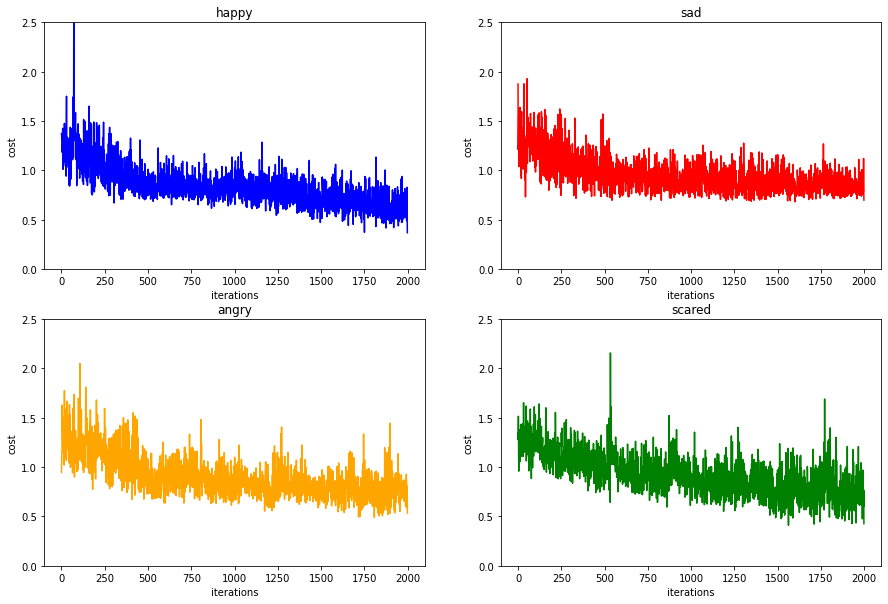

In [70]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
import matplotlib.pyplot as plt

colours = ['blue', 'red', 'orange', 'green']

for i in range(4):
    axs[i//2, i%2].plot(ps[classes[i]][1][51:], color=colours[i]) #excluding the first 51 values since they are used for calibraiton
    axs[i//2, i%2].set_title(classes[i])

    axs[i//2, i%2].set_xlabel('iterations')
    axs[i//2, i%2].set_ylabel('cost')
    axs[i//2, i%2].set_ylim(0,2.5)
